# Cosine scheduler, revisited

> In this module, we radically simlify the DDPM algorithm by constraining time between 0 and 1

Adapted from

- [https://www.youtube.com/watch?v=PXiD7ZjOKhA&t=2s](https://www.youtube.com/watch?v=PXiD7ZjOKhA&t=2s)

The idea we'll be exploring is the removing the concept of having $\frac{t}{T}$

In [1]:
#| default_exp cos_revisited

In [11]:
# |export
import math
from functools import lru_cache, partial
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import lr_scheduler
from tqdm import tqdm

from slowai.ddim import fashion_unet
from slowai.ddpm import DDPM, get_dls, train
from slowai.learner import (
    Callback,
    DeviceCB,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    after,
    def_device,
    only,
)
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_images

In [12]:
# |export
def aesthetics():
    plt.style.use("ggplot")
    matplotlib.rcParams["image.cmap"] = "gray_r"

In [13]:
aesthetics()

Often in diffusion, we refer to time steps like so

```python
T = 1000
for t in range(T):
    print(f"Progress: {t/T}")
```

Jeremy notes that we can simply use a progress variable $\in [0, 1]$. This allows us to simplify the $\bar{\alpha}$ expression like so:

In [14]:
# |export
@lru_cache
def ᾱ(t, reshape=True, device=def_device):
    assert (0 <= t).all() and (t <= 1).all()
    ᾱ_ = ((t * math.pi / 2).cos() ** 2).clamp(0.0, 0.999)
    if reshape:
        ᾱ_ = ᾱ_.reshape(-1, 1, 1, 1)
    return ᾱ_

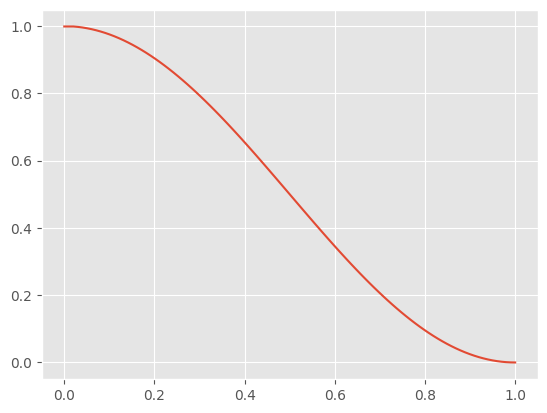

In [15]:
x = torch.linspace(0, 1, 100)
plt.plot(x, ᾱ(x, reshape=False));

And, furthermore, the noisify function can be simplified like so:

In [16]:
# |export
def noisify(x_0, t=None):
    n, *_ = x_0.shape
    device = x_0.device

    if t is None:
        t = torch.rand((n,), device=device)

    # Sample 2D noise for each example in the batch
    ε = torch.randn(x_0.shape, device=device)

    # Add noise according to the equation in Algorithm 1, such
    # that the variance of the distribution does not change
    x_t = ᾱ(t).sqrt() * x_0 + (1 - ᾱ(t)).sqrt() * ε

    return ((x_t, t), ε)

Now, (a) we don't have to deal with knowing the time steps, computing $\alpha$ and $\beta$ and (b) the process is continuous.

Let's add this to the DDPM training callback. Notice that the constructor has been deleted.

In [17]:
# |export
class ContinuousDDPM(DDPM, order=after(DeviceCB)):
    def before_batch(self, learn):
        x_0, _ = learn.batch
        learn.batch = noisify(x_0)

    @only
    def predict(self, learn):
        (x_t, t), _ = learn.batch
        learn.preds = learn.model(x_t, t).sample

In [18]:
dls = get_dls()
xb, _ = dls.peek()
xb.shape  # Note: 32x32

torch.Size([128, 1, 32, 32])

We can use the parameters from our training run in the previous notebook.

loss,epoch,train
0.072,0,train
0.044,0,eval
0.039,1,train
0.037,1,eval
0.035,2,train
0.034,2,eval
0.033,3,train
0.032,3,eval
0.032,4,train
0.032,4,eval


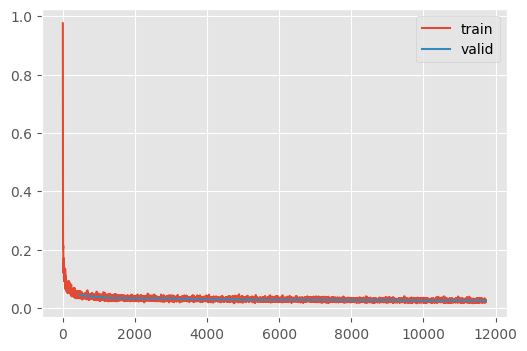

In [19]:
fp = Path("../models/fashion_unet_2x_continuous.pt")
ddpm = ContinuousDDPM(βmax=0.01)
if fp.exists():
    unet = torch.load(fp)
else:
    unet = fashion_unet()
    train(
        unet,
        lr=1e-2,
        n_epochs=25,
        bs=128,
        opt_func=partial(torch.optim.Adam, eps=1e-5),
        ddpm=ddpm,
    )
    torch.save(unet, fp)

To denoise, we need to reverse the noisification. Recall, for a given sample $x_0$, the noised sample is defined as:
    x_t = ᾱ_t.sqrt() * x_0 + (1 - ᾱ_t).sqrt() * ε
$$
x_t = \sqrt{ \bar{\alpha}_t } x_0 + \left( \sqrt{ 1 - \bar{\alpha}_t } \right) \epsilon
$$

Thus,

$$
x_0 = \frac{ x_t - \left( \sqrt{ 1 - \bar{\alpha}_t } \right) \epsilon }{ \sqrt{ \bar{\alpha}_t } }
$$

In [25]:
# |export
def denoisify(x_t, noise, t):
    return (x_t - (1 - ᾱ(t)).sqrt() * noise) / ᾱ(t).sqrt()

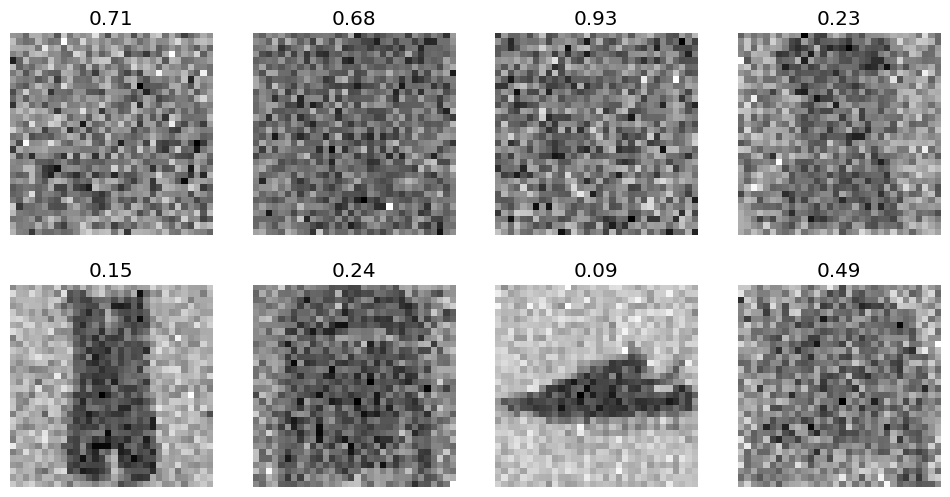

In [26]:
(x_t, ts), eps = noisify(xb)
show_images(x_t[:8], titles=[f"{t.item():.2f}" for t in ts[:8]])

This looks impressive for one step, but recall `xb` is part of the training data.

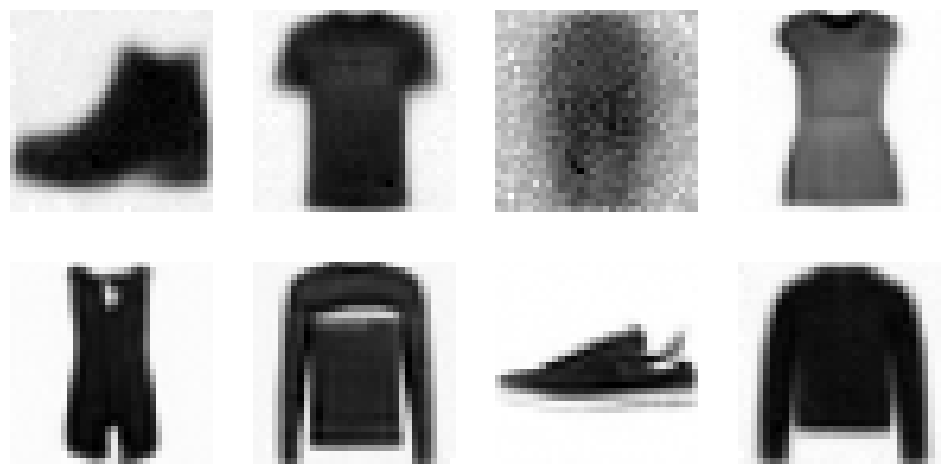

In [27]:
eps_pred = unet(x_t.to(def_device), ts.to(def_device)).sample
x_0 = denoisify(x_t, eps_pred.cpu(), ts)
show_images(x_0[:8])

Finally, we can rewrite the sampling algorithm without any $\alpha$s or $\beta$s. The only function we need is $\bar{\alpha}_t$, which are part of the `noisify` and `denoisify` functions. This also means we can make the sampler a single, elegant function.

In [28]:
# |export
@torch.no_grad()
def ddpm(model, sz=(16, 1, 32, 32), device=def_device, n_steps=100):
    x_t = torch.randn(sz, device=device)
    ts = torch.linspace(1 - (1 / n_steps), 0, n_steps).to(device)
    for t, t_next in tqdm(zip(ts, ts[1:]), unit="time step", total=n_steps - 1):
        # Predict the noise for each example in the image
        noise_pred = model(x_t, t).sample

        # Predict the image without noise
        x_0_pred = denoisify(x_t, noise_pred, t)

        # Renoise
        (prev_sample, _), _ = noisify(x_0_pred, t_next)

        # Repeat
        x_t = prev_sample

    # At the last step, simply rescale and do not add noise
    t = tensor(0.0, device=device)
    x_0 = denoisify(x_t, model(x_t, t).sample, t)

    return x_t

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 69.75time step/s]


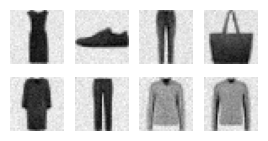

In [32]:
x_0 = ddpm(unet, sz=(8, 1, 32, 32), n_steps=100)
show_images(x_0, imsize=0.8)

This code had a few bugs in it initially that led to deep-fried results.

- `denoisify` was given `torch.randn` instead of `noise_pred`
- The last denoising iteration was given `t=1` instead of `t=0`

Let's try this with DDIM

In [56]:
# |export
class DDIM:
    @staticmethod
    def noisify(η, x_0_pred, noise_pred, t, t_next):
        σ_t = η * ((1 - ᾱ(t_next)) / (1 - ᾱ(t))).sqrt() * (1 - ᾱ(t) / ᾱ(t_next)).sqrt()
        ε_t = torch.randn(x_0_pred.shape).to(x_0_pred.device)
        x_t = (
            # Scale \hat{x}_0
            ᾱ(t_next).sqrt() * x_0_pred
            # Step towards x_{t-1}
            + (1 - ᾱ(t_next) - σ_t**2).sqrt() * noise_pred
        )
        # Add noise
        if t_next > 0:
            x_t += σ_t * ε_t
        return x_t


@torch.no_grad()
def ddim(model, sz=(16, 1, 32, 32), device=def_device, n_steps=100, eta=1.0):
    x_t = torch.randn(sz, device=device)
    ts = torch.linspace(1 - (1 / n_steps), 0, n_steps).to(device)
    for t, t_next in tqdm(zip(ts, ts[1:]), unit="time step", total=n_steps - 1):
        # Predict the noise for each example in the image
        noise_pred = model(x_t, t).sample

        # Predict the image without noise
        x_0_pred = denoisify(x_t, noise_pred, t)

        # Renoise, if needed
        prev_sample = DDIM.noisify(eta, x_0_pred, noise_pred, t, t_next)

        # Repeat
        x_t = prev_sample

    x_0 = denoisify(x_t, noise_pred, t)

    return x_0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 68.83time step/s]


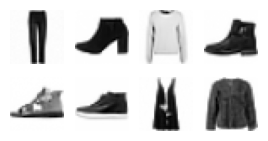

In [59]:
x_0 = ddim(unet, sz=(8, 1, 32, 32), n_steps=100)
show_images(x_0, imsize=0.8)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()